# Association Rules in Python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# Package Installation
try:
    import mlxtend
except:
    !pip install mlxtend

try:
    import wordcloud
except:
    !pip install wordcloud

try:
    import networkx
except:
    !pip install networkx
    
try:
    import plotly
except:
    !pip install plotly
    
    
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from collections import Counter
from wordcloud import WordCloud
import networkx as nx
import plotly.express as px

import warnings
warnings.filterwarnings(action='ignore')

# Part 1: Transform a data file into transaction format

In [2]:
# Basket type
transactions = []
with open("Transaction_Sample_Basket.csv", "r") as file:
    for line in file:
        transactions.append(" ".join(line.strip().split(",")).strip())

pd.Series(transactions, name='items')

0        A B C
1      A C D E
2        A E B
3        B C D
4        F A B
5      A D F G
6    G F B C E
7          A B
8          C D
9        C F G
Name: items, dtype: object

In [3]:
# Single type
single_df = pd.read_csv('Transaction_Sample_Single.csv', header=None)
single_df.columns = ['transactionID']

single_df['transactionID'] = single_df['transactionID'].apply(lambda x: x.strip())
single_df = single_df['transactionID'].str.split(' ', expand=True)
single_df.columns = ['transactionID','items']

single_df.groupby('transactionID')['items'].unique()

transactionID
Tr1           [A, B, C]
Tr10             [C, G]
Tr2        [A, C, D, E]
Tr3           [A, E, B]
Tr4           [B, C, D]
Tr5           [F, A, B]
Tr6        [A, D, F, G]
Tr7     [G, F, B, C, E]
Tr8              [A, B]
Tr9                 [C]
Name: items, dtype: object

# Part 2: Association Rule Mining without sequence information

In [4]:
groceries_df = pd.read_csv('groceries_data.csv')

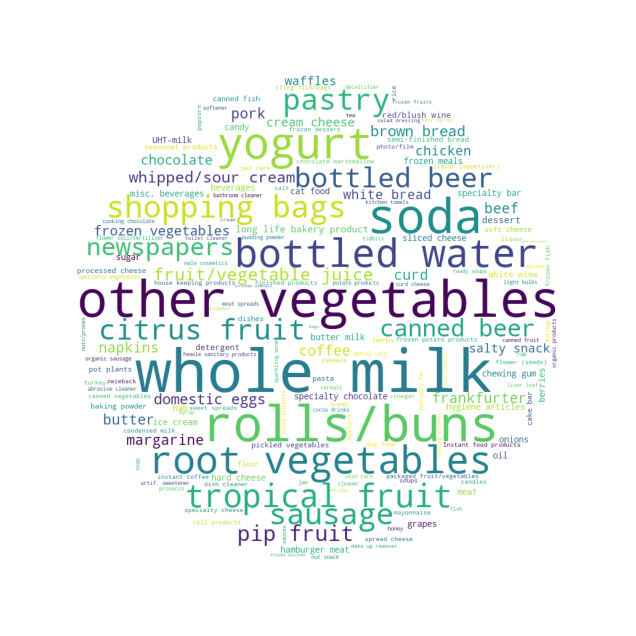

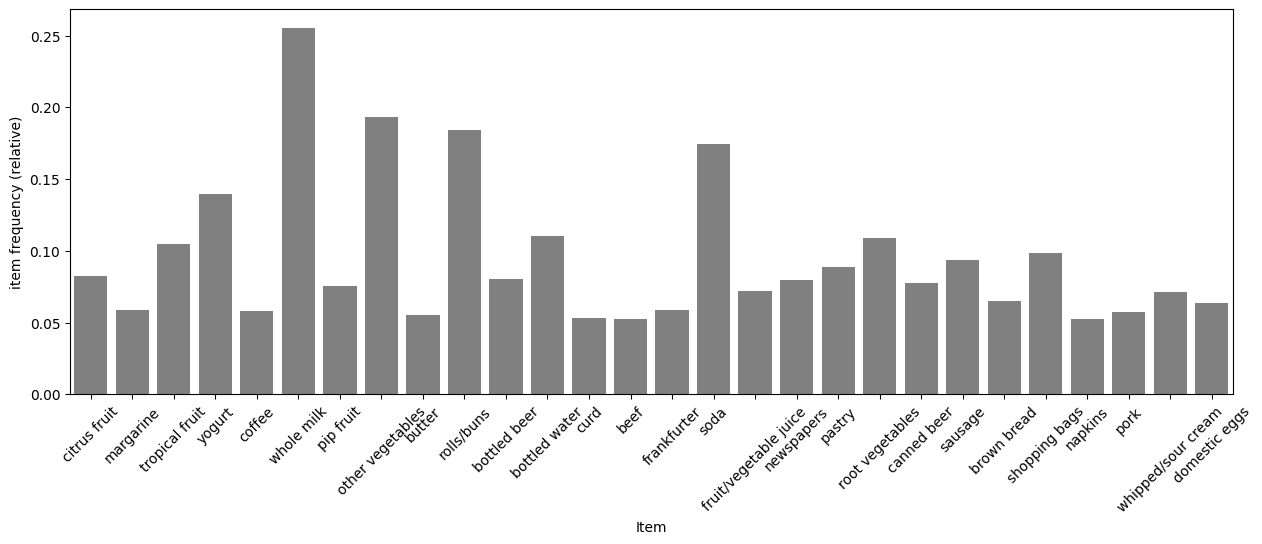

In [5]:
# Item inspection
items = ",".join(sum(groceries_df.values.tolist(), [])).split(',')
items = [item.strip() for item in items]
item_count = Counter(items)

x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(
    width            = 1000, 
    height           = 500, 
    mask             = mask,
    background_color = 'white'
).generate_from_frequencies(item_count)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Item frequency (relative)
freq_df = pd.DataFrame({
    'item' : item_count.keys(),
    'freq'  : item_count.values()
})

freq_df['ratio'] = freq_df['freq'] / len(groceries_df)

plt.figure(figsize=(15,5))
sns.barplot(
    x    = 'item',
    y    = 'ratio',
    color = 'gray',
    data = freq_df.query('ratio >= 0.05')
)
plt.xlabel("Item")
plt.ylabel("item frequency (relative)")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Rule generation by Apriori
item_list = []

for items in sum(groceries_df.values.tolist(),[]):
    item_list.append(items.split(','))

groceries_te = TransactionEncoder()
groceries_transactions = groceries_te.fit_transform(item_list)
groceries_transactions = pd.DataFrame(groceries_transactions, columns=groceries_te.columns_)

frequent_itemsets = apriori(groceries_transactions, min_support=0.01, use_colnames=True, verbose=True)

# Association Rule Generation
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.35)

rules.sort_values('lift')

Processing 128 combinations | Sampling itemset size 43


antecedents         consequents  antecedent support  \
2                           (berries)        (whole milk)            0.033249   
24         (long life bakery product)        (whole milk)            0.037417   
18            (fruit/vegetable juice)        (whole milk)            0.072293   
10                     (citrus fruit)        (whole milk)            0.082766   
13                          (dessert)        (whole milk)            0.037112   
..                                ...                 ...                 ...   
63      (root vegetables, rolls/buns)  (other vegetables)            0.024301   
53                 (whole milk, curd)            (yogurt)            0.026131   
65  (root vegetables, tropical fruit)  (other vegetables)            0.021047   
47    (root vegetables, citrus fruit)  (other vegetables)            0.017692   
48   (other vegetables, citrus fruit)   (root vegetables)            0.028876   

    consequent support   support  confidence      lift  leverage  conviction  
2             0.255516  0.011795    0.354740  1.388328  0.003299    1.153774  
24            0.255516  0.013523    0.361413  1.414444  0.003962    1.165830  
18            0.255516  0.026640    0.368495  1.442160  0.008168    1.178904  
10            0.255516  0.030503    0.368550  1.442377  0.009355    1.179008  
13            0.255516  0.013726    0.369863  1.447514  0.004244    1.181464  
..                 ...       ...         ...       ...       ...         ...  
63            0.193493  0.012201    0.502092  2.594890  0.007499    1.619792  
53            0.139502  0.010066    0.385214  2.761356  0.006421    1.399671  
65            0.193493  0.012303    0.584541  3.020999  0.008231    1.941244  
47            0.193493  0.010371    0.586207  3.029608  0.006948    1.949059  
48            0.108998  0.010371    0.359155  3.295045  0.007224    1.390354  

[89 rows x 9 columns]

In [9]:
# Save the rules in a text file
rules.to_csv('Groceries_rules.csv', index=False)

# Plot the rules

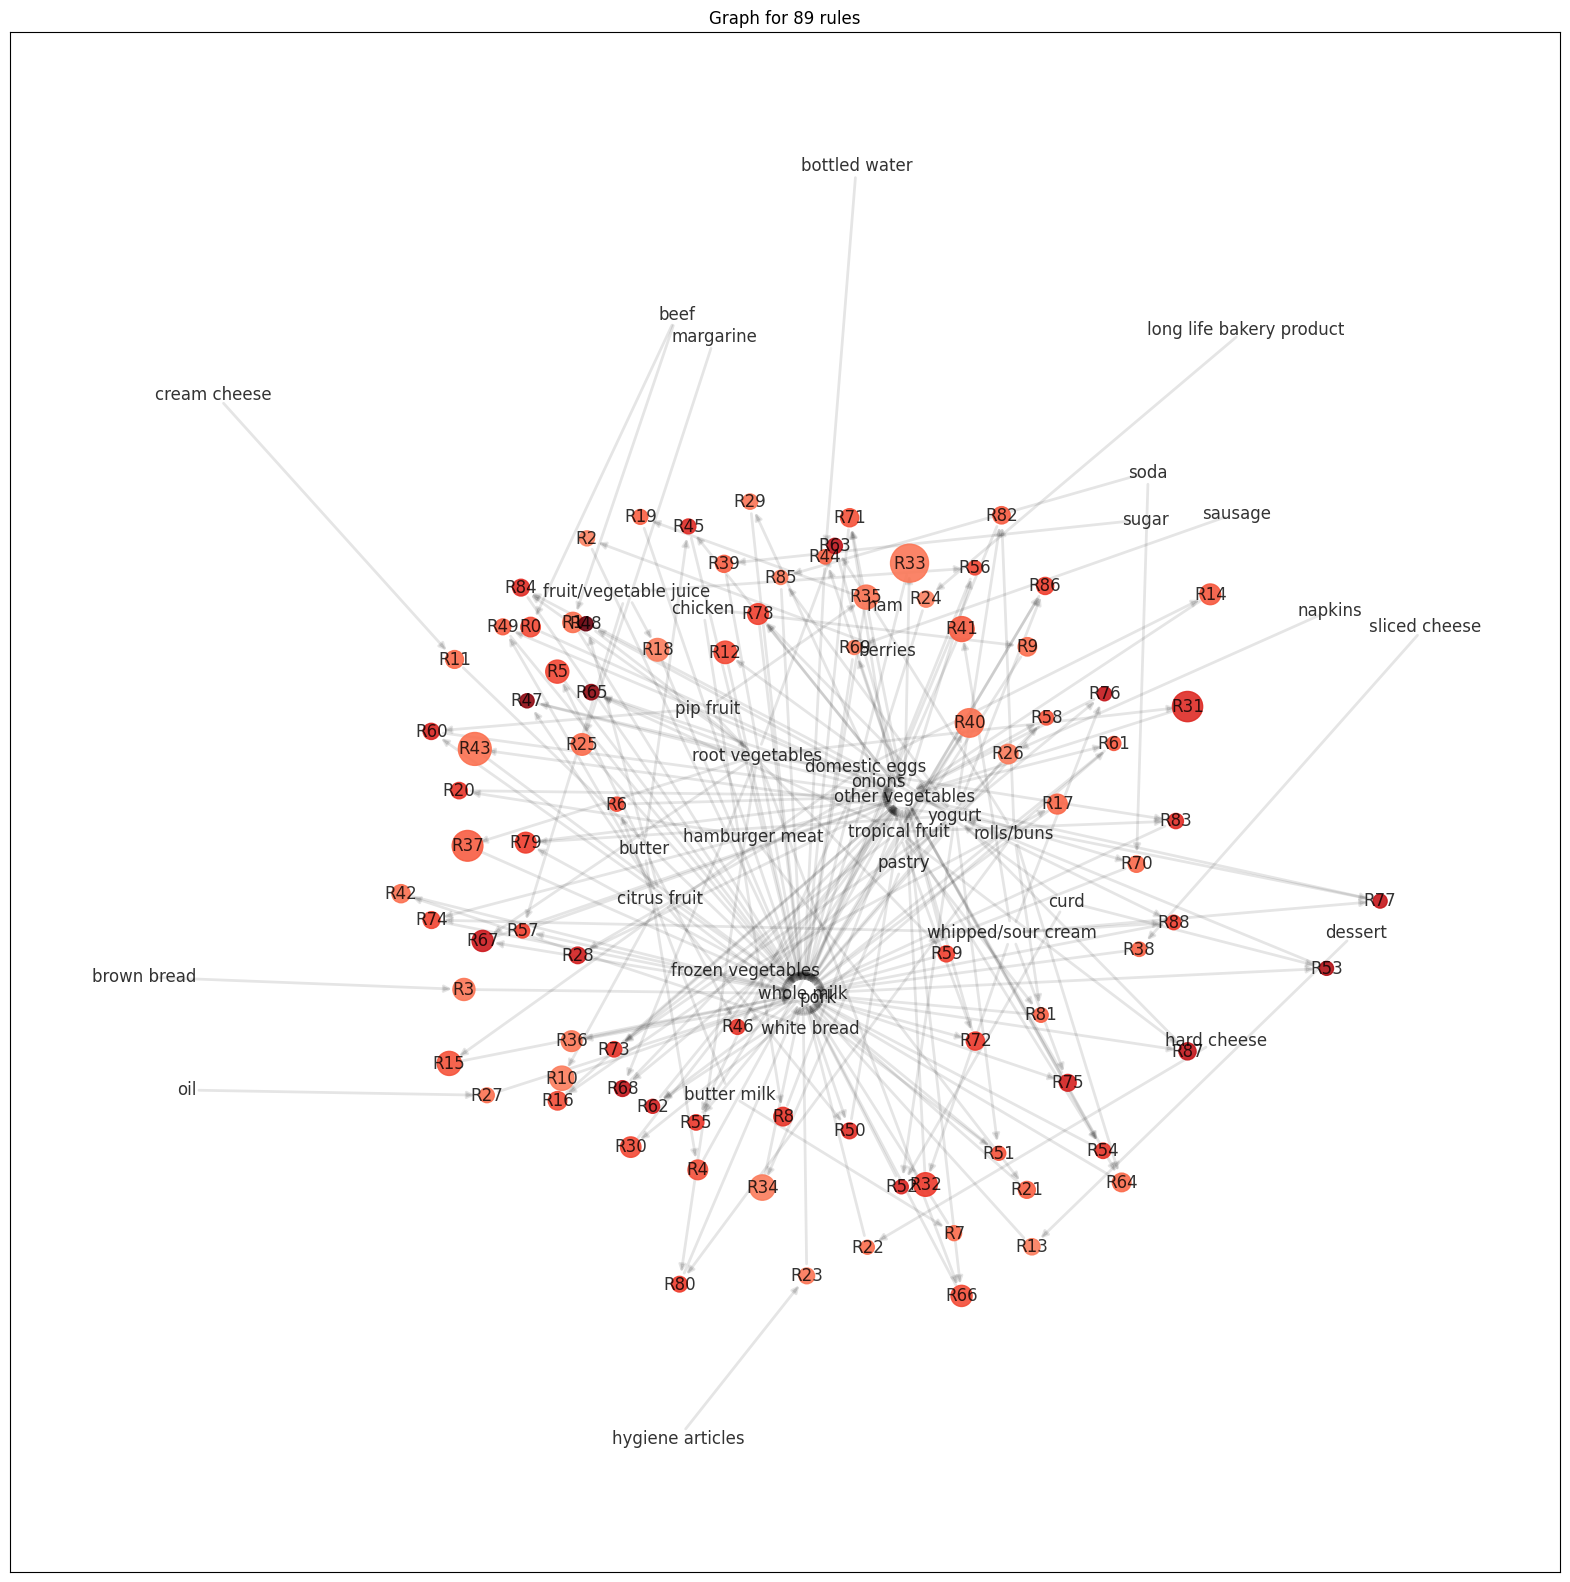

In [10]:
def draw_graph_rules(rules, iterations: int = 8):
    rules_to_show = len(rules)
    # Directional Graph from NetworkX
    network = nx.DiGraph()

    # Loop through number of rules to show
    for i in range(rules_to_show):
        # Add a Rule Node
        network.add_nodes_from(["R"+str(i)])

        for antecedents in rules.iloc[i]['antecedents']: 
            # Add antecedent node and link to rule
            network.add_nodes_from([antecedents])
            network.add_edge(antecedents, "R"+str(i),  weight=2)

        for consequents in rules.iloc[i]['consequents']:
            # Add consequent node and link to rule
            network.add_nodes_from([consequents])
            network.add_edge("R"+str(i), consequents,  weight=2)


    # For every node, set color and size
    color_map = []  
    size = []

    i = 0
    for node in network:
        if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append(rules.iloc[i]['lift'])
            size.append(rules.iloc[i]['support'])
            i+=1
        else:
            color_map.append(0)
            size.append(0) 

    # Position nodes using spring layout
    pos = nx.spring_layout(network, iterations=8, seed=42)
    plt.figure(figsize=(20,20))

    nx.draw_networkx_nodes(
        G          = network, 
        pos        = pos, 
        node_color = [c*100 for c in color_map], 
        node_size  = [s*10000 for s in size], 
        cmap       = plt.cm.Reds, 
        alpha      = 0.9
    )
    nx.draw_networkx_edges(
        G         = network, 
        pos       = pos, 
        alpha     = 0.1,
        width     = 2, 
        edge_cmap = plt.cm.Greys
    )
    nx.draw_networkx_labels(
        G     = network, 
        pos   = pos, 
        alpha = 0.8
    )
    
    plt.title(f"Graph for {len(rules)} rules")
    plt.show()
    
draw_graph_rules(rules=rules)

In [11]:
rules['rule'] = rules.apply(lambda x: f"{list(x.antecedents)} -> {list(x.consequents)}", axis=1)

def scatter_plot_rules(rules):
    fig = px.scatter(
        data_frame             = rules,
        x                      = "support",
        y                      = "confidence",
        color                  = 'lift',
        hover_name             = "rule",
        width                  = 700,
        height                 = 1000,
        color_continuous_scale = px.colors.sequential.Reds
    )
    fig.show()
    
scatter_plot_rules(rules=rules)

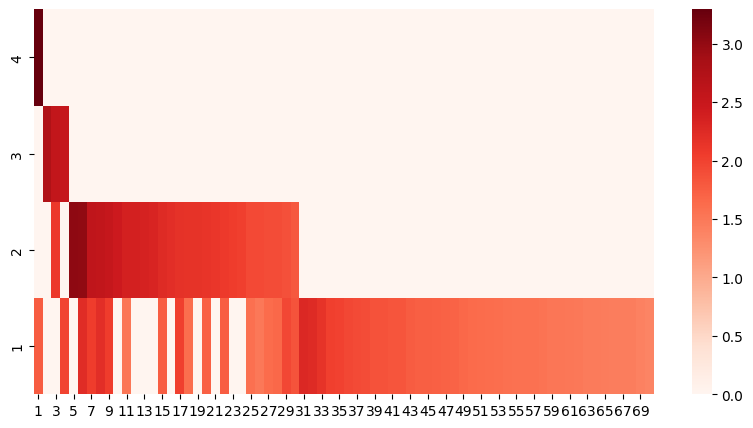

In [12]:
# Matrix

def matrix_plot_rules(rules):
    rules_mtx = rules.groupby(['antecedents','consequents'])['lift'].sum().unstack()

    order_idx = rules_mtx.count().sort_values().index.tolist()

    rules_mtx = rules_mtx.fillna(0)
    rules_mtx = rules_mtx.sort_values(order_idx, ascending=False)[order_idx].T

    rules_mtx.index = range(len(rules_mtx.index), 0, -1)
    rules_mtx.columns = range(1, len(rules_mtx.columns)+1)

    # Plot Heatmap
    plt.figure(figsize=(10,5))
    sns.heatmap(data=rules_mtx, cmap='Reds')
    plt.show()
    
matrix_plot_rules(rules=rules)

In [13]:
frequent_itemsets = apriori(groceries_transactions, min_support=0.01, use_colnames=True, verbose=True)

# Association Rule Generation
rules_001_050 = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
rules_001_050.sort_values('lift')

Processing 128 combinations | Sampling itemset size 43


antecedents         consequents  \
8   (other vegetables, whipped/sour cream)        (whole milk)   
9               (yogurt, other vegetables)        (whole milk)   
13                (yogurt, tropical fruit)        (whole milk)   
4            (other vegetables, pip fruit)        (whole milk)   
10           (root vegetables, rolls/buns)        (whole milk)   
14            (yogurt, whipped/sour cream)        (whole milk)   
3        (other vegetables, domestic eggs)        (whole milk)   
12               (root vegetables, yogurt)        (whole milk)   
11       (root vegetables, tropical fruit)        (whole milk)   
0               (butter, other vegetables)        (whole milk)   
2                           (yogurt, curd)        (whole milk)   
7                (yogurt, root vegetables)  (other vegetables)   
5            (root vegetables, rolls/buns)  (other vegetables)   
6        (root vegetables, tropical fruit)  (other vegetables)   
1          (root vegetables, citrus fruit)  (other vegetables)   

    antecedent support  consequent support   support  confidence      lift  \
8             0.028876            0.255516  0.014642    0.507042  1.984385   
9             0.043416            0.255516  0.022267    0.512881  2.007235   
13            0.029283            0.255516  0.015150    0.517361  2.024770   
4             0.026131            0.255516  0.013523    0.517510  2.025351   
10            0.024301            0.255516  0.012710    0.523013  2.046888   
14            0.020742            0.255516  0.010880    0.524510  2.052747   
3             0.022267            0.255516  0.012303    0.552511  2.162336   
12            0.025826            0.255516  0.014540    0.562992  2.203354   
11            0.021047            0.255516  0.011998    0.570048  2.230969   
0             0.020031            0.255516  0.011490    0.573604  2.244885   
2             0.017285            0.255516  0.010066    0.582353  2.279125   
7             0.025826            0.193493  0.012913    0.500000  2.584078   
5             0.024301            0.193493  0.012201    0.502092  2.594890   
6             0.021047            0.193493  0.012303    0.584541  3.020999   
1             0.017692            0.193493  0.010371    0.586207  3.029608   

    leverage  conviction  
8   0.007263    1.510239  
9   0.011174    1.528340  
13  0.007668    1.542528  
4   0.006846    1.543003  
10  0.006500    1.560804  
14  0.005580    1.565719  
3   0.006613    1.663694  
12  0.007941    1.703594  
11  0.006620    1.731553  
0   0.006371    1.745992  
2   0.005649    1.782567  
7   0.007916    1.613015  
5   0.007499    1.619792  
6   0.008231    1.941244  
1   0.006948    1.949059

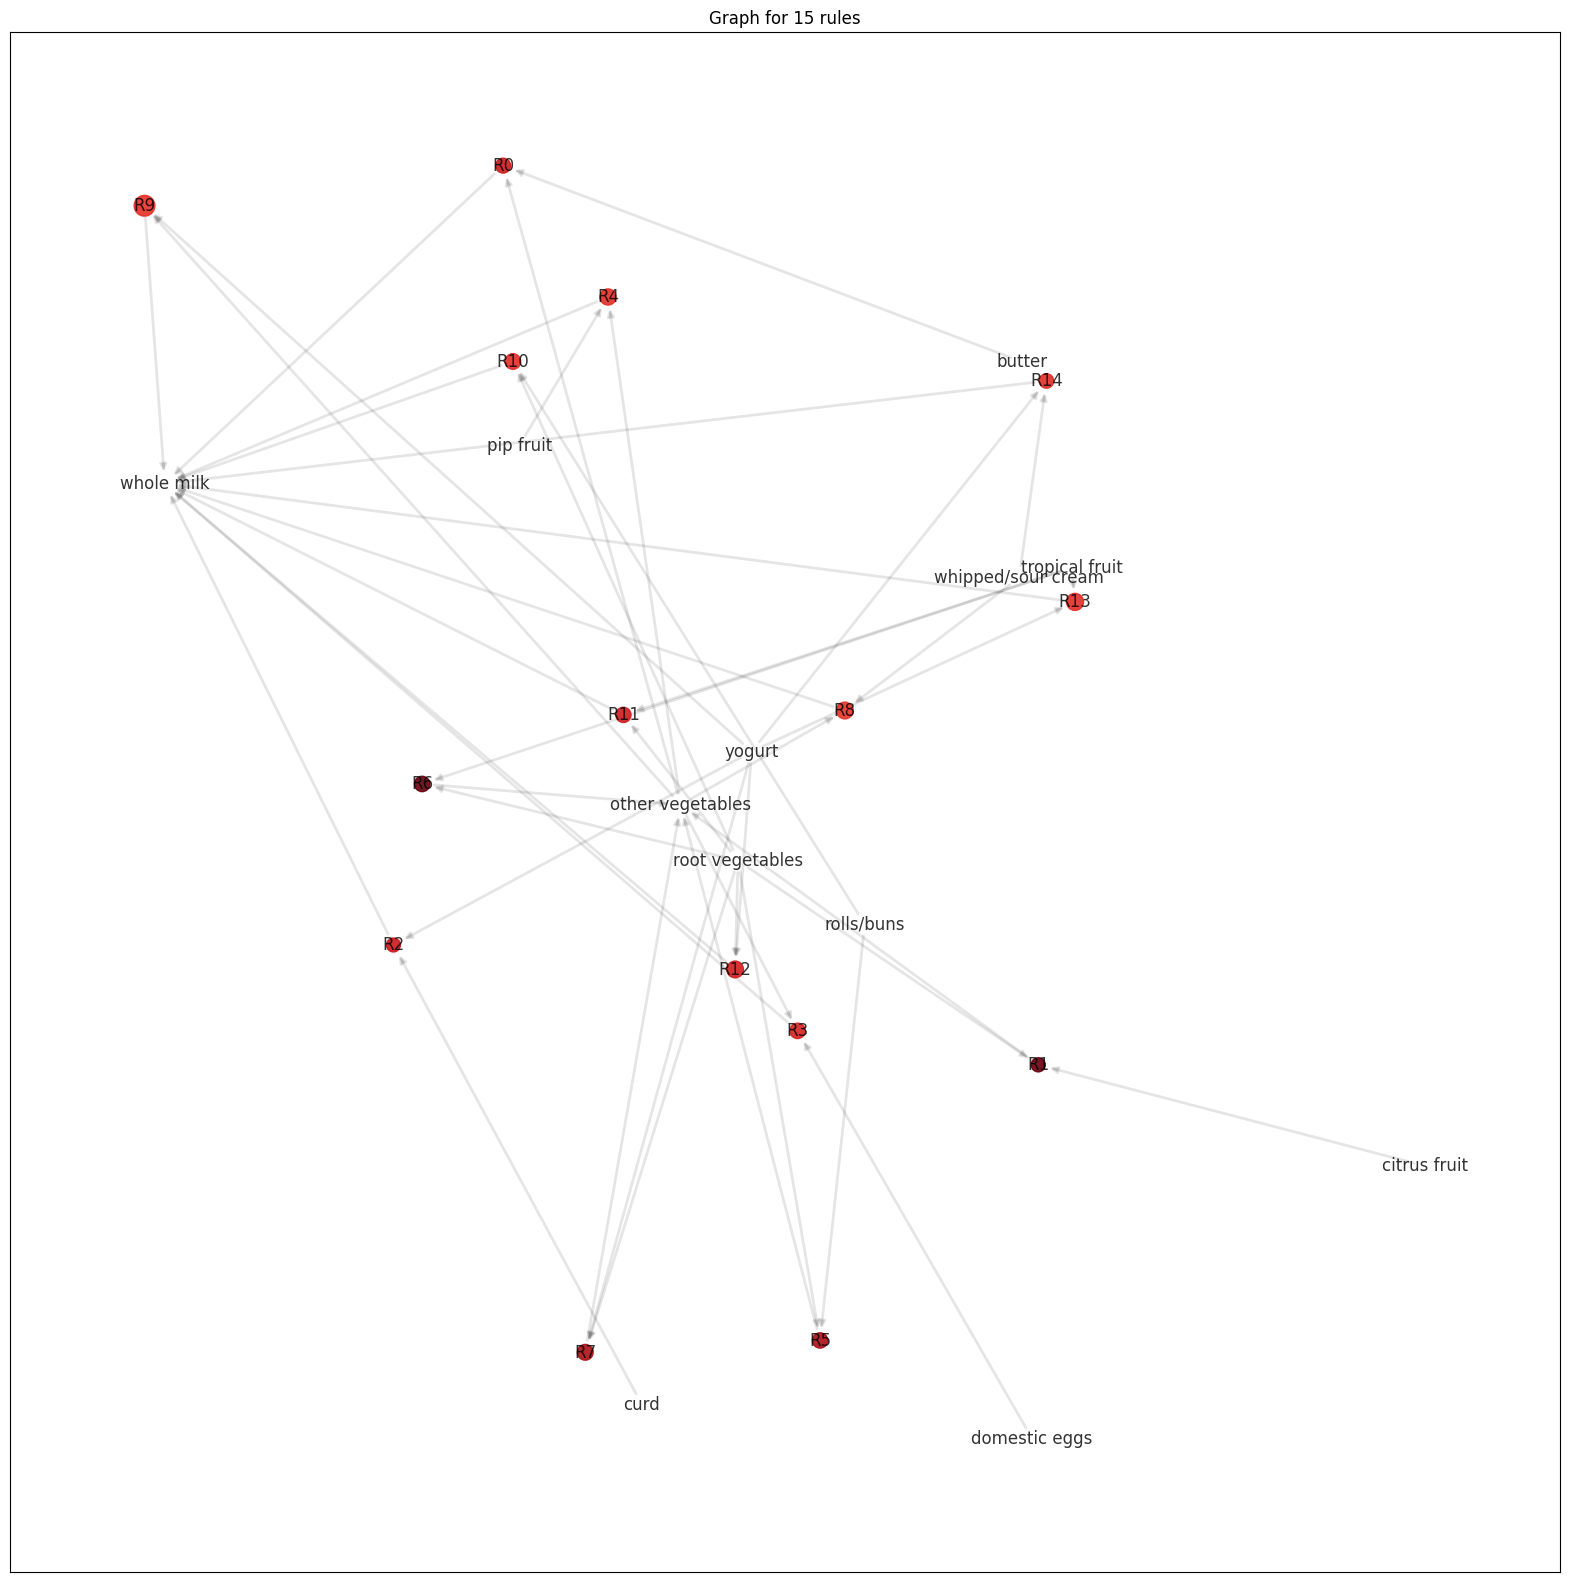

In [14]:
draw_graph_rules(rules=rules_001_050, iterations=100)